In [7]:
import os
#from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
#from keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.preprocessing.image import ImageDataGenerator, load_img
#from keras.applications.resnet50 import ResNet50
#from keras.preprocessing import image
#from keras.models import Sequential
#from keras.models import Model
#from keras.callbacks import ModelCheckpoint, EarlyStopping
#import matplotlib.pyplot as plt
#import numpy as np
import joblib


from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [19]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def preprocess(train_data_dir, valid_data_dir, test_data_dir):
    img_height, img_width = (227, 227)  # Image dimensions assumed for AlexNet
    batch_size = 32

    # Data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = train_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical')

    # Preprocess images using LDA
    lda = LDA()
    lda.fit(train_generator[0][0].reshape(-1, img_height * img_width * 3), np.argmax(train_generator[0][1], axis=1))

    # Transform image data using LDA
    lda_train_data = lda.transform(train_generator[0][0].reshape(-1, img_height * img_width * 3))
    lda_valid_data = lda.transform(valid_generator[0][0].reshape(-1, img_height * img_width * 3))
    lda_test_data = lda.transform(test_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Get the target variables
    lda_train_target = np.argmax(train_generator[0][1], axis=1)
    lda_valid_target = np.argmax(valid_generator[0][1], axis=1)
    lda_test_target = np.argmax(test_generator[0][1], axis=1)

    # Create new generators with transformed data and target variables
    lda_train_generator = (lda_train_data, train_generator[0][1])
    lda_valid_generator = (lda_valid_data, valid_generator[0][1])
    lda_test_generator = (lda_test_data, test_generator[0][1])

    return lda, lda_train_generator, lda_test_generator, lda_valid_generator

def model_trainer(epochs=10):
    train_data_dir = "/workspace/data/data_dir/model-data/train"
    test_data_dir = "/workspace/data/data_dir/model-data/test"
    valid_data_dir = "/workspace/data/data_dir/model-data/val"

    lda, lda_train_generator, lda_test_generator, lda_valid_generator = preprocess(
        train_data_dir=train_data_dir,
        test_data_dir=test_data_dir,
        valid_data_dir=valid_data_dir)

    num_classes = lda_train_generator[1].shape[1]  # Get number of classes from the generator
    print("Number of classes:", num_classes)

    input_shape = (lda_train_generator[0].shape[1],)  # Adjust input shape according to LDA components
    print("Input shape:", input_shape)

    model = lda_model(input_shape, num_classes)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_callback = ModelCheckpoint('/workspace/data/data_dir/saved/best/best_model.h5',
                                          monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    log_dir = "/workspace/data/data_dir/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    model.fit(
        lda_train_generator[0],
        lda_train_generator[1],
        epochs=epochs,
        validation_data=(lda_valid_generator[0], lda_valid_generator[1]),
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
    )

    return model

if __name__ == '__main__':
    lda_model = model_trainer(epochs=10)
    lda_model.save('/workspace/data/data_dir/saved/saved_model.h5')


Found 1750 images belonging to 3 classes.
Found 249 images belonging to 3 classes.
Found 502 images belonging to 3 classes.
Number of classes: 3
Input shape: (1,)
Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.1065 - accuracy: 0.0312
Epoch 1: val_loss improved from inf to 1.01812, saving model to /workspace/data/data_dir/saved/best/best_model.h5
1/1 [==============================] - 1s 611ms/step - loss: 1.1065 - accuracy: 0.0312 - val_loss: 1.0181 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.8438
Epoch 2: val_loss improved from 1.01812 to 0.96098, saving model to /workspace/data/data_dir/saved/best/best_model.h5
1/1 [==============================] - 0s 109ms/step - loss: 1.0400 - accuracy: 0.8438 - val_loss: 0.9610 - val_accuracy: 0.7812
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.8438
Epoch 3: val_loss improved from 0.96098 to 0.91842, saving model to /wo

In [20]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
def preprocess(train_data_dir, valid_data_dir, test_data_dir):
    img_height, img_width = (227, 227)  # Image dimensions assumed for AlexNet
    batch_size = 32

    # Data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = train_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical')

    # Preprocess images using LDA
    lda = LDA()
    lda.fit(train_generator[0][0].reshape(-1, img_height * img_width * 3), np.argmax(train_generator[0][1], axis=1))

    # Transform image data using LDA
    lda_train_data = lda.transform(train_generator[0][0].reshape(-1, img_height * img_width * 3))
    lda_valid_data = lda.transform(valid_generator[0][0].reshape(-1, img_height * img_width * 3))
    lda_test_data = lda.transform(test_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Get the target variables
    lda_train_target = np.argmax(train_generator[0][1], axis=1)
    lda_valid_target = np.argmax(valid_generator[0][1], axis=1)
    lda_test_target = np.argmax(test_generator[0][1], axis=1)

    # Create new generators with transformed data and target variables
    lda_train_generator = (lda_train_data, train_generator[0][1])
    lda_valid_generator = (lda_valid_data, valid_generator[0][1])
    lda_test_generator = (lda_test_data, test_generator[0][1])

    return lda, lda_train_generator, lda_test_generator, lda_valid_generator

def model_trainer(epochs=10):
    train_data_dir = "/workspace/data/data_dir/model-data/train"
    test_data_dir = "/workspace/data/data_dir/model-data/test"
    valid_data_dir = "/workspace/data/data_dir/model-data/val"

    lda, lda_train_generator, lda_test_generator, lda_valid_generator = preprocess(
        train_data_dir=train_data_dir,
        test_data_dir=test_data_dir,
        valid_data_dir=valid_data_dir)

    num_classes = lda_train_generator[1].shape[1]  # Get number of classes from the generator
    input_shape = (lda_train_generator[0].shape[1],)  # Adjust input shape according to LDA components

    model = lda_model(input_shape, num_classes)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_callback = ModelCheckpoint('/workspace/data/data_dir/saved/best/best_model.h5',
                                          monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    log_dir = "/workspace/data/data_dir/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    history = model.fit(
        lda_train_generator[0],
        lda_train_generator[1],
        epochs=epochs,
        validation_data=(lda_valid_generator[0], lda_valid_generator[1]),
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
    )

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return model

if __name__ == '__main__':
    lda_model = model_trainer(epochs=10)
    lda_model.save('/workspace/data/data_dir/saved/saved_model.h5')

Found 1750 images belonging to 3 classes.
Found 249 images belonging to 3 classes.
Found 502 images belonging to 3 classes.


ValueError: Exception encountered when calling layer "model_1" (type Functional).

Input 0 of layer "flatten_1" is incompatible with the layer: expected min_ndim=1, found ndim=0. Full shape received: ()

Call arguments received by layer "model_1" (type Functional):
  • inputs=('tf.Tensor(shape=(), dtype=int32)',)
  • training=3
  • mask=None

Found 1750 images belonging to 3 classes.
Found 249 images belonging to 3 classes.
Found 502 images belonging to 3 classes.
Number of classes: 3
Input shape: (1,)
Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.0798 - accuracy: 0.8438
Epoch 1: val_loss improved from inf to 0.97392, saving model to /workspace/data/data_dir/saved/best/best_model.h5
1/1 [==============================] - 1s 616ms/step - loss: 1.0798 - accuracy: 0.8438 - val_loss: 0.9739 - val_accuracy: 0.9375
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.0024 - accuracy: 0.8438
Epoch 2: val_loss did not improve from 0.97392
1/1 [==============================] - 0s 188ms/step - loss: 1.0024 - accuracy: 0.8438 - val_loss: 0.9818 - val_accuracy: 0.5625
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.8125
Epoch 3: val_loss did not improve from 0.97392
1/1 [==============================] - 0s 113ms/step - loss: 0.9389 - accuracy: 0.8125 - val_lo

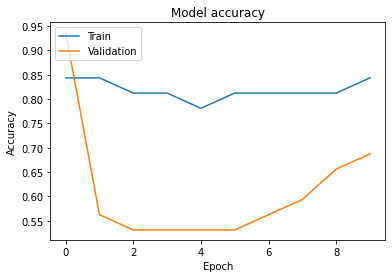

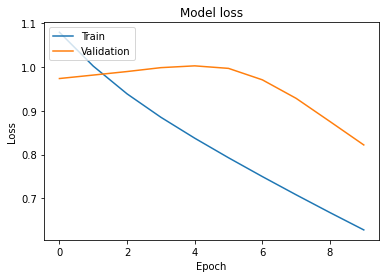

In [24]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

def preprocess(train_data_dir, valid_data_dir, test_data_dir):
    img_height, img_width = (227, 227)  # Image dimensions assumed for AlexNet
    batch_size = 32

    # Data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = train_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical')

    # Preprocess images using LDA
    lda = LDA()
    lda.fit(train_generator[0][0].reshape(-1, img_height * img_width * 3), np.argmax(train_generator[0][1], axis=1))

    # Transform image data using LDA
    lda_train_data = lda.transform(train_generator[0][0].reshape(-1, img_height * img_width * 3))
    lda_valid_data = lda.transform(valid_generator[0][0].reshape(-1, img_height * img_width * 3))
    lda_test_data = lda.transform(test_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Get the target variables
    lda_train_target = train_generator[0][1]  # No need to convert to argmax
    lda_valid_target = valid_generator[0][1]  # No need to convert to argmax
    lda_test_target = test_generator[0][1]    # No need to convert to argmax

    return lda, (lda_train_data, lda_train_target), (lda_test_data, lda_test_target), (lda_valid_data, lda_valid_target)

def lda_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Flatten layer
    x = Flatten()(input_layer)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=predictions)

    return model

def model_trainer(epochs=10):
    train_data_dir = "/workspace/data/data_dir/model-data/train"
    test_data_dir = "/workspace/data/data_dir/model-data/test"
    valid_data_dir = "/workspace/data/data_dir/model-data/val"

    lda, (lda_train_data, lda_train_target), (lda_test_data, lda_test_target), (lda_valid_data, lda_valid_target) = preprocess(
        train_data_dir=train_data_dir,
        test_data_dir=test_data_dir,
        valid_data_dir=valid_data_dir)

    num_classes = lda_train_target.shape[1]  # Get number of classes from the target
    print("Number of classes:", num_classes)

    input_shape = (lda_train_data.shape[1],)  # Adjust input shape according to LDA components
    print("Input shape:", input_shape)

    model = lda_model(input_shape, num_classes)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_callback = ModelCheckpoint('/workspace/data/data_dir/saved/best/best_model.h5',
                                          monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    log_dir = "/workspace/data/data_dir/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    history = model.fit(
        lda_train_data,
        lda_train_target,
        epochs=epochs,
        validation_data=(lda_valid_data, lda_valid_target),
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
    )

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return model

if __name__ == '__main__':
    lda_model = model_trainer(epochs=10)
    lda_model.save('/workspace/data/data_dir/saved/saved_model.h5')

    